# 2. Repostas topico 2:


## 1. Carregamento dos dados e libs:

In [174]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report



df = pd.read_csv('..\data\processed\df_eda01_plus_5000.csv')

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
C:\Users\guima\AppData\Local\Temp\ipykernel_24716\2678984867.py:18: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\data\processed\df_eda01_plus_5000.csv')


Testando o carregamento

In [175]:
df.head()

,Series_Title,Released_Year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Runtime,Gross,budget
0,the godfather,1972.0,A,9.2,organized crime dynastys aging patriarch trans...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,...,0,0,0,0,0,0,0,175.0,134966411.0,6000000.0
1,the dark knight,2008.0,UA,9.0,menace known Joker wreaks havoc chaos people G...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,...,0,0,0,0,0,0,0,152.0,534858444.0,185000000.0
2,the godfather: part ii,1974.0,A,9.0,early life career Vito Corleone 1920s New York...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,...,0,0,0,0,0,0,0,202.0,57300000.0,13000000.0
3,12 angry men,1957.0,U,9.0,jury holdout attempts prevent miscarriage just...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,...,0,0,0,0,0,0,0,96.0,4360000.0,350000.0
4,the lord of the rings: the return of the king,2003.0,U,8.9,Gandalf Aragorn lead World Men Saurons army dr...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,...,0,0,0,0,0,0,0,201.0,377845905.0,94000000.0


## 2.a Qual filme você recomendaria para uma pessoa que você não conhece?

Como não sabemos nada sobre os gostos da pessoa, a recomendação deve ser baseada em fatores que indiquem qualidade e aceitação geral.  
Os critérios considerados foram:  

- **Qualidade (IMDB_Rating)** → avaliação média dos usuários do IMDb.  
- **Popularidade (No_of_Votes)** → número de votos recebidos, indicando relevância e alcance.  
- **Classificação Etária (Certificate)** → quanto mais ampla, maior a chance de agradar diferentes públicos.  

### Codigo usado para analise: 

In [176]:
#mapeamento peso classficação
CERT_MAP = {
    "G": 1.0, "TV-G": 1.0,
    "PG": 0.9, "TV-PG": 0.9,
    "PG-13": 0.8, "TV-14": 0.8, "U": 0.8, "U/A": 0.8,
    "A": 0.7, "UA": 0.7, "Approved": 0.7, "Passed": 0.7, "GP": 0.7, "M": 0.7,
    "R": 0.6, "Unrated": 0.6, "Not Rated": 0.6,
    "X": 0.4, "NC-17": 0.4, "TV-MA": 0.4, "16": 0.4,
}

def add_cert_score(s):
    """Converte Certificate em um score numérico (0–1). Onde não mapear, usa 0.6."""
    return s.map(CERT_MAP).fillna(0.6)

def minmax_norm(df_in, cols):
    """Normaliza colunas numéricas com MinMax, retornando um DataFrame com sufixo _norm."""
    out = df_in.copy()
    scaler = MinMaxScaler()
    # Evitar erro se alguma coluna for constante:
    X = out[cols].astype(float).values
    if np.ptp(X, axis=0).sum() == 0:  
        for c in cols:
            out[f"{c}_norm"] = 0.0
        return out
    norm_vals = scaler.fit_transform(X)
    for i, c in enumerate(cols):
        out[f"{c}_norm"] = norm_vals[:, i]
    return out

def rank_principal(df, weights=None, topn=10, return_full=False):


    if weights is None:
        weights = {"rating": 1.0, "votes": 1.0, "cert": 1.0}

    cols_needed = ["Series_Title", "IMDB_Rating", "No_of_Votes", "Certificate"]
    d = df[cols_needed].dropna(subset=["IMDB_Rating", "No_of_Votes"]).copy()

    d["cert_score"] = add_cert_score(d["Certificate"])
    d = minmax_norm(d, ["IMDB_Rating", "No_of_Votes"])  

    d["score_total"] = (
        weights["rating"] * d["IMDB_Rating_norm"]
        + weights["votes"] * d["No_of_Votes_norm"]
        + weights["cert"]  * d["cert_score"]
    )

    d = d.sort_values("score_total", ascending=False)
    return d if return_full else d[["Series_Title", "IMDB_Rating", "No_of_Votes", "Certificate", "cert_score", "score_total"]].head(topn)

def rank_complementar(df, weights=None, topn=10, return_full=False):
    
    if weights is None:
        weights = {"rating": 1.0, "votes": 1.0, "meta": 1.0, "cert": 1.0}

    cols_needed = ["Series_Title", "IMDB_Rating", "No_of_Votes", "Meta_score", "Certificate"]
    d = df[cols_needed].dropna(subset=["IMDB_Rating", "No_of_Votes", "Meta_score"]).copy()

    d["cert_score"] = add_cert_score(d["Certificate"])
    d = minmax_norm(d, ["IMDB_Rating", "No_of_Votes", "Meta_score"])

    d["score_total"] = (
        weights["rating"] * d["IMDB_Rating_norm"]
        + weights["votes"] * d["No_of_Votes_norm"]
        + weights["meta"]  * d["Meta_score_norm"]
        + weights["cert"]  * d["cert_score"]
    )

    d = d.sort_values("score_total", ascending=False)
    return d if return_full else d[["Series_Title", "IMDB_Rating", "No_of_Votes", "Meta_score", "Certificate", "cert_score", "score_total"]].head(topn)


### Ranking Principal (cobertura total da base)  
Esse ranking considera **todos os filmes** da base, usando apenas variáveis disponíveis para todos (`IMDB_Rating`, `No_of_Votes` e `Certificate`).  
Os filmes melhor ranqueados combinam alta nota, grande popularidade e classificação mais abrangente.  

**Top 5 – Ranking Principal**:  
1. *The Dark Knight*  
2. *Inception*  
3. *The Lord of the Rings: The Return of the King*  
4. *The Lord of the Rings: The Fellowship of the Ring*  
5. *Pulp Fiction*  

> Se fosse recomendar para alguém sem conhecer seus gostos, usaria este ranking como base.  
> Nesse caso, **The Dark Knight** é o mais indicado, pois combina excelente avaliação, enorme número de votos e classificação relativamente acessível.  

In [177]:
# Pesos (ajuste se quiser enfatizar algum fator)
weights_main = {"rating": 1.0, "votes": 1.0, "cert": 1.0}

rank_main_top5 = rank_principal(df, weights=weights_main, topn=5, return_full=False)
rank_main_top5


,Series_Title,IMDB_Rating,No_of_Votes,Certificate,cert_score,score_total
1,the dark knight,9.0,2303232,UA,0.7,2.660526
7,inception,8.8,2067042,UA,0.7,2.531663
4,the lord of the rings: the return of the king,8.9,1642758,U,0.8,2.460608
9,the lord of the rings: the fellowship of the ring,8.8,1661481,U,0.8,2.455579
5,pulp fiction,8.9,1826188,A,0.7,2.440249


### Ranking Complementar (quando disponível o Meta_score)  
Além do público, também é interessante considerar a **opinião da crítica profissional** (`Meta_score`).  
Esse ranking foi construído apenas para os filmes que possuem essa variável preenchida, somando-a aos demais critérios.  

**Top 5 – Ranking Complementar**:  
1. *The Godfather*  
2. *The Dark Knight*  
3. *The Lord of the Rings: The Return of the King*  
4. *Pulp Fiction*  
5. *The Lord of the Rings: The Fellowship of the Ring*  

> Esse ranking mostra que, quando a crítica é considerada, **The Godfather** assume a liderança, reforçando sua posição histórica como um dos filmes mais bem avaliados de todos os tempos.  

In [178]:
# Pesos (ajuste se quiser dar menos/mais importância para meta)
weights_meta = {"rating": 1.0, "votes": 1.0, "meta": 1.0, "cert": 1.0}

rank_meta_top5 = rank_complementar(df, weights=weights_meta, topn=5, return_full=False)
rank_meta_top5


,Series_Title,IMDB_Rating,No_of_Votes,Meta_score,Certificate,cert_score,score_total
0,the godfather,9.2,1620367,100.0,A,0.7,3.400239
1,the dark knight,9.0,2303232,84.0,UA,0.7,3.352778
4,the lord of the rings: the return of the king,8.9,1642758,94.0,U,0.8,3.239235
5,pulp fiction,8.9,1826188,94.0,A,0.7,3.219756
9,the lord of the rings: the fellowship of the ring,8.8,1661481,92.0,U,0.8,3.157176


## Conclusão – Pergunta 2.a  

Se fosse necessário recomendar **um único filme** para uma pessoa que eu não conheço, minha escolha seria: **The Dark Knight (2008)**  

**Motivos da escolha:**  
1. **Equilíbrio entre público e crítica** → aparece no topo tanto do ranking principal (público + popularidade + classificação) quanto do ranking complementar (inclui também o *Meta_score*).  
2. **Popularidade massiva** → mais de 2,3 milhões de votos no IMDb, garantindo ampla aceitação e relevância global.  
3. **Qualidade consistente** → nota 9.0 no IMDb e *Meta_score* de 84, ou seja, bem avaliado por usuários e críticos.  
4. **Classificação etária acessível** → `PG-13` / `UA`, permitindo que o filme seja indicado para um público amplo, não restrito apenas a adultos.  

**Resumo:**  
Entre todas as opções analisadas, *The Dark Knight* é a recomendação mais robusta, pois combina **alta qualidade, grande popularidade, boa recepção da crítica e alcance para diferentes públicos**.  


## 2.b Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?  


Para investigar os fatores relacionados ao faturamento (*Gross*), foram consideradas variáveis numéricas e categóricas do dataset.

### Possíveis fatores analisados
- **Budget** → maior investimento em produção tende a gerar maior bilheteria.  
- **No_of_Votes** → número de votos indica popularidade e tamanho do público.  
- **IMDB_Rating** → filmes bem avaliados podem ter melhor desempenho no boca a boca.  
- **Runtime** → filmes muito curtos ou muito longos podem afetar a adesão do público.  
- **Certificate** → classificações etárias restritivas podem reduzir a audiência potencial.  
- **Genres_list** → gêneros como ação, aventura e ficção científica tendem a gerar mais receita que dramas independentes.  

> **Nota:** A variável *Meta_score* foi descartada da análise geral, já que estava ausente na maior parte da base unificada.  
> Além disso, mesmo na base original de 1000 filmes, sua correlação com faturamento foi de apenas **0.03**, reforçando a decisão de não considerá-la como determinante.
  

### 1. Heatmap de correlação  
- **Número de votos (0.58)** → é o fator mais fortemente correlacionado com faturamento, mostrando que popularidade anda junto com bilheteria.  
- **Runtime (0.24)** → correlação positiva, indicando que a duração pode ter algum impacto.  
- **IMDB_Rating (0.21)** → correlação fraca, reforçando que boas notas não garantem alto faturamento.  
- **Budget (0.10)** → apresentou correlação muito baixa com `Gross`.  

### Conclusão
Os resultados indicam que o **engajamento do público** (*número de votos*) é o principal fator associado ao faturamento.  
Outros aspectos como tempo de duração e avaliação do público têm efeito mais discreto.  

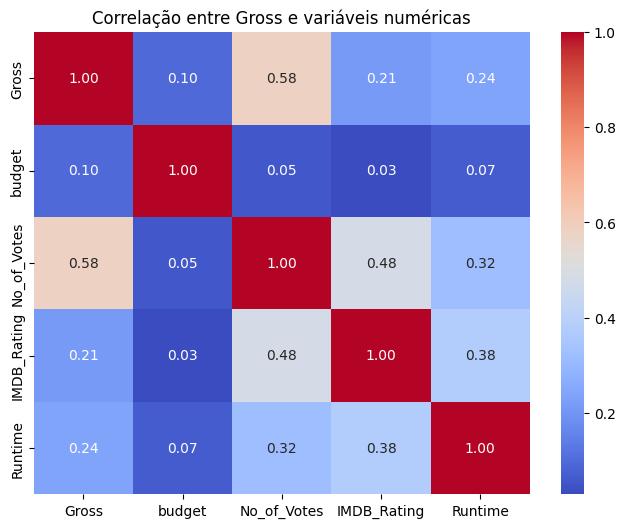

In [207]:

# Selecionar colunas numéricas relevantes
cols_num = ["Gross", "budget", "No_of_Votes", "IMDB_Rating", "Runtime"]

df_corr = df[cols_num].dropna()

# Matriz de correlação
corr_matrix = df_corr.corr()

# Plotar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre Gross e variáveis numéricas")
plt.show()


### 2. Dispersão Votos × Gross (escala log-log)  
- A correlação é positiva: mais votos → maior bilheteria.  
- Esse padrão faz sentido, já que votos refletem engajamento e número de espectadores.  
- A reta de tendência mostra uma relação quase linear no log-log.  

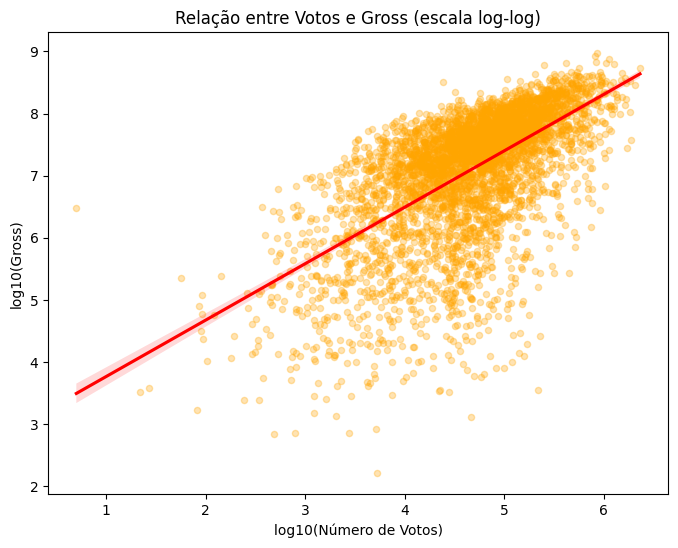

In [181]:
df_plot = df[(df["No_of_Votes"] > 0) & (df["Gross"] > 0)].copy()
df_plot["log_votes"] = np.log10(df_plot["No_of_Votes"])
df_plot["log_gross"] = np.log10(df_plot["Gross"])

plt.figure(figsize=(8,6))
sns.regplot(
    data=df_plot,
    x="log_votes", y="log_gross",
    scatter_kws={"alpha":0.3, "s":20, "color":"orange"},
    line_kws={"color":"red"}
)
plt.title("Relação entre Votos e Gross (escala log-log)")
plt.xlabel("log10(Número de Votos)")
plt.ylabel("log10(Gross)")
plt.show()


### 3. Média de Gross por Gênero  
- Top gêneros em faturamento médio: Animation, Adventure, Sci-Fi, Family, Action, Fantasy.  
- Gêneros “blockbuster” dominam a bilheteria, enquanto Film-Noir, Drama, Horror e Western têm faturamentos médios mais baixos.  
- Filmes de apelo familiar e de grande espetáculo visual são os mais rentáveis.  

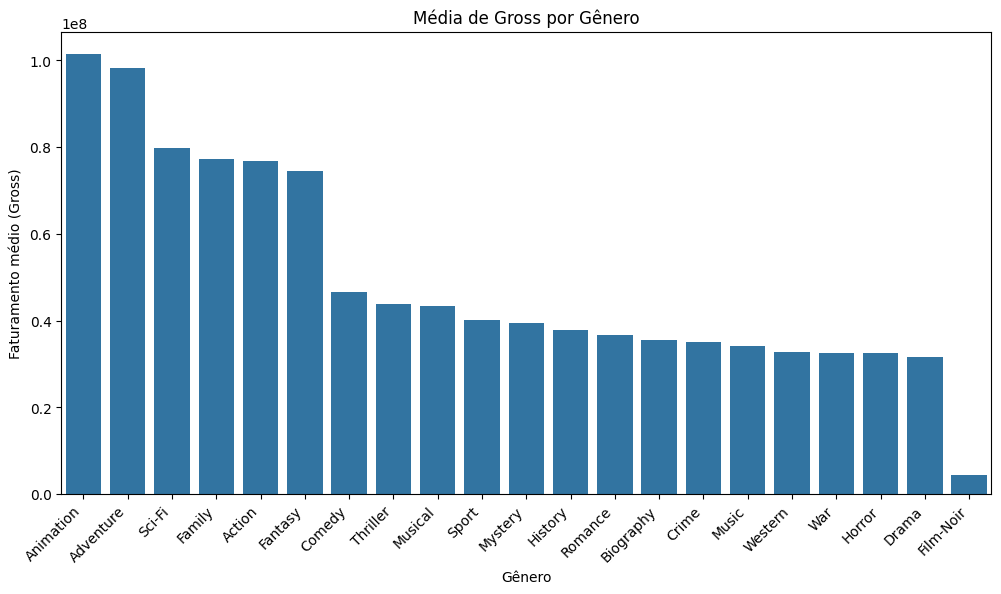

In [182]:
# Lista de colunas de gênero
genre_cols = [
    'Action','Adventure','Animation','Biography','Comedy','Crime','Drama',
    'Family','Fantasy','Film-Noir','History','Horror','Music','Musical',
    'Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western'
]
# Calcular a média de Gross por gênero
gross_by_genre = {}
for g in genre_cols:
    filmes_gen = df[df[g] == 1]  # pega apenas filmes daquele gênero
    gross_by_genre[g] = filmes_gen["Gross"].mean()

# Transformar em DataFrame ordenado
gross_by_genre = (
    pd.DataFrame.from_dict(gross_by_genre, orient="index", columns=["Gross_mean"])
    .sort_values("Gross_mean", ascending=False)
)

# Gráfico
plt.figure(figsize=(12,6))
sns.barplot(x=gross_by_genre.index, y="Gross_mean", data=gross_by_genre)
plt.title("Média de Gross por Gênero")
plt.ylabel("Faturamento médio (Gross)")
plt.xlabel("Gênero")
plt.xticks(rotation=45, ha="right")
plt.show()


### 4. Média de Gross por Certificate  
- UA, U, A, PG e PG-13 concentram os maiores faturamentos médios.  
- Filmes com classificação mais restritiva (ex.: R, NC-17, TV-MA) tendem a arrecadar menos.  
- Isso reforça que classificações etárias amplas maximizam público e receita.

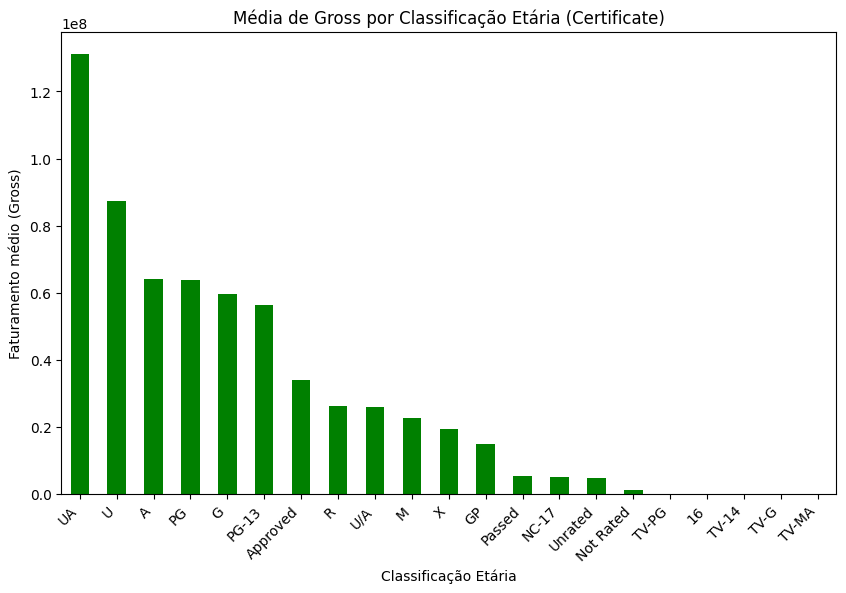

In [183]:
gross_by_cert = df.groupby("Certificate")["Gross"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
gross_by_cert.plot(kind="bar", color="green")
plt.title("Média de Gross por Classificação Etária (Certificate)")
plt.ylabel("Faturamento médio (Gross)")
plt.xlabel("Classificação Etária")
plt.xticks(rotation=45, ha="right")
plt.show()


## Conclusão geral da 2.b  

Os fatores mais associados a alto faturamento são:  
1. **Popularidade (número de votos)** → principal indicador de bilheteria, mostrando que filmes que engajam mais público tendem a arrecadar mais.  
2. **Gênero** → produções de ação, aventura, ficção científica, fantasia, família e animação tendem a apresentar maior potencial de retorno em comparação a dramas independentes, por exemplo.  
3. **Classificação etária ampla (PG, PG-13, U, UA)** → aumenta o alcance do público, facilitando maior arrecadação.  

Por outro lado, fatores como **nota do IMDb**, **Budget** e **duração (Runtime)** mostraram correlação fraca, sugerindo impacto muito menor sobre a receita.


## 2.c Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?


#### O que temos na coluna?

A coluna *Overview* contém uma breve descrição do enredo de cada filme. Ela permite análises textuais (NLP) que revelam padrões de vocabulário associados a gêneros, épocas de lançamento e até diferenças entre filmes bem e mal avaliados.

Abaixo iremos explorar alguns insights iteressantes dessa coluna:


### Principais Insights:

#### 1. Palavras mais frequentes por gênero

Ao separar os filmes pelos gêneros (Action, Adventure, Comedy, etc.), observamos que cada um possui um vocabulário característico:  

- **Action:** *police, agent, battle, death*  
- **Adventure:** *alien, world, space*  
- **Animation:** *princess, girl, boy*  
- **Biography:** *true, love, war*  

Esse insight mostra como a coluna *Overview* traduz diretamente os **elementos centrais de cada gênero**, ajudando a entender os tópicos dominantes que aparecem nos filmes.

In [184]:


WORD_RE = re.compile(r"[a-zA-Z]{3,}")  

def tokenize_series(series: pd.Series) -> itertools.chain:
    texts = series.fillna("").astype(str).str.lower()
    return itertools.chain.from_iterable(texts.map(WORD_RE.findall))

def top_words_for_mask(
    df: pd.DataFrame,
    mask: pd.Series,
    overview_col: str = "Overview",
    stopwords: set | None = None,
    topn: int = 20
):
    tokens = tokenize_series(df.loc[mask, overview_col])
    if stopwords:
        tokens = (t for t in tokens if t not in stopwords)
    return Counter(tokens).most_common(topn)

def top_words_by_genre_pure(
    df: pd.DataFrame,
    overview_col: str,
    genre_cols: list,
    stopwords: set | None = None,
    topn: int = 20
) -> dict:
    out = {}
    for g in genre_cols:
        if g in df.columns:
            mask = df[g] == 1
            if mask.any():
                out[g] = top_words_for_mask(df, mask, overview_col, stopwords, topn)
    return out

# ===== EXEMPLO DE USO =====
stopwords_basic = {
    # adicione outras se quiser
    "the","and","for","with","from","that","this","when","into","their","about",
    "film","films","movie","story","stories","based","life","family","young"
}

top_por_genero_puro = top_words_by_genre_pure(
    df, "Overview", genre_cols, stopwords=stopwords_basic, topn=20
)

for g, itens in top_por_genero_puro.items():
    print(f"\n=== {g} ===")
    for termo, cnt in itens[:5]:
        print(f"{termo:<15} {cnt}")



=== Action ===
police          90
agent           58
female          56
battle          49
death           44

=== Adventure ===
alien           46
world           40
new             38
space           34
girl            34

=== Animation ===
title           21
new             20
girl            19
boy             16
princess        16

=== Biography ===
true            20
war             19
love            18
american        17
female          17

=== Comedy ===
friend          129
female          128
love            125
title           124
school          122

=== Crime ===
police          119
murder          107
fbi             72
female          56
nudity          55

=== Drama ===
love            189
new             155
nudity          149
female          144
friend          143

=== Family ===
dog             42
title           36
christmas       35
boy             33
school          32

=== Fantasy ===
death           38
love            34
vampire         29
time            25


----------------------------

#### 2. Palavras mais comuns por década
Agrupando por década, também foi possível identificar termos dominantes:  

- **1940:** *war* (reflexo da Segunda Guerra Mundial)  
- **1950:** *murder* (popularidade do noir/crime)  
- **2000:** *love* (forte presença de dramas e romances)  
- **2010:** *female* (mais protagonismo feminino nas narrativas)  

Essa análise mostra como os temas centrais dos filmes mudam ao longo do tempo.

In [185]:


def top_word_and_count_per_decade(
    df: pd.DataFrame,
    overview_col: str = "Overview",
    year_col: str = "Released_Year",
    token_min_len: int = 3,
):
    years = pd.to_numeric(df[year_col], errors="coerce").dropna().astype(int)
    decades = (years // 10) * 10
    dfx = df.loc[years.index].assign(decade=decades)

    stop = set(ENGLISH_STOP_WORDS) | {
        "film","films","movie","story","stories","based","true","life",
        "man","woman","young","new","title"
    }
    token_pattern = rf"(?u)\b[a-zA-Z]{{{token_min_len},}}\b"

    rows = []
    for dec, sub in dfx.groupby("decade"):
        texts = sub[overview_col].fillna("").astype(str).values
        if len(texts) == 0:
            continue

        vec = CountVectorizer(
            lowercase=True,
            stop_words=list(stop),
            token_pattern=token_pattern,
            min_df=1,
            max_df=1.0
        )
        X = vec.fit_transform(texts)
        if X.shape[1] == 0:
            continue

        vocab = np.array(vec.get_feature_names_out())
        counts = X.sum(axis=0).A1
        max_count = counts.max()
        # pega a(s) palavras com essa contagem
        top_mask = counts == max_count
        candidates = vocab[top_mask]
        top_term = np.sort(candidates)[0]  # desempate por ordem alfabética

        rows.append({"decade": int(dec), "term": top_term, "count": int(max_count)})

    return pd.DataFrame(rows).sort_values("decade").reset_index(drop=True)

# ===== USO =====
df_top_word_decade = top_word_and_count_per_decade(df, "Overview", "Released_Year")
print(df_top_word_decade)


    decade      term  count
0     1910  huguenot      1
1     1920      city      2
2     1930      help      6
3     1940       war      5
4     1950    murder     10
5     1960       war     10
6     1970      town      8
7     1980    nudity     21
8     1990    female     52
9     2000      love    125
10    2010    female     87
11    2020  broadway      2


### É possível inferir o gênero do filme a partir dessa coluna?

**Sim.** A sinopse do filme contém vocabulário característico que pode ser usado para prever o gênero.  
Existem duas formas principais de fazer isso:

#### 1) Abordagem Clássica (TF-IDF + Regressão Logística)

- **Funcionamento:**  
  - As sinopses são transformadas em vetores numéricos com TF-IDF (palavras e combinações mais frequentes).  
  - Um classificador multilabel aprende a identificar a presença de cada gênero.  

- **Resultados (exemplo):**  
  - F1-micro ≈ 0.52, F1-macro ≈ 0.42  
  - Melhores: *Drama*, *Action*, *Sci-Fi*  
  - Piores (raros): *Film-Noir*, *Musical*  

- **Interpretação:**  
  - O modelo identifica termos típicos por gênero:  
    - *War*: `soldier, german, navy, submarine`  
    - *Western*: `cowboy, outlaw, gunfighter`  

Essa abordagem é rápida, barata e interpretável, servindo como um bom baseline.

Limitações: sofre com gêneros raros; depende da qualidade do texto e do idioma; não entende muito contexto além do n-grama.

In [186]:
X_text = df["Overview"].fillna("").astype(str)
Y = (
    df[genre_cols]
    .fillna(0)
    .clip(lower=0, upper=1)       # evita valores fora de 0/1 se existirem
    .astype(int)
    .values
)

X_train, X_test, y_train, y_test = train_test_split(
    X_text, Y, test_size=0.2, random_state=42, stratify=None  # multilabel não usa stratify direto
)


stop = set(ENGLISH_STOP_WORDS) | {
    "film","films","movie","story","stories","based","true","life",
    "man","woman","young","new","title"
}
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words=list(stop),
    ngram_range=(1,2),
    min_df=3,
    max_df=0.98,
    max_features=100_000
)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)


base = LogisticRegression(
    C=4.0, solver="liblinear", max_iter=2000, class_weight="balanced"
)
clf = MultiOutputClassifier(base)
clf.fit(Xtr, y_train)


y_proba_list = [est.predict_proba(Xte)[:, 1] for est in clf.estimators_]
y_proba = np.vstack(y_proba_list).T
y_pred = (y_proba >= 0.5).astype(int)

print("F1 micro:", f1_score(y_test, y_pred, average="micro"))
print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("\nRelatório por gênero:\n")
print(classification_report(y_test, y_pred, target_names=genre_cols, zero_division=0))

feature_names = np.array(tfidf.get_feature_names_out())

def top_terms_for_estimator(estimator, k=10):
    coefs = estimator.coef_.ravel()
    top_idx = np.argsort(coefs)[::-1][:k]
    return feature_names[top_idx]

for g, est in zip(genre_cols, clf.estimators_):
    tops = top_terms_for_estimator(est, k=10)
    print(f"\n=== {g} ===")
    print(", ".join(map(str, tops)))


F1 micro: 0.5243399969479627
F1 macro: 0.4234522614967295

Relatório por gênero:

              precision    recall  f1-score   support

      Action       0.55      0.69      0.61       243
   Adventure       0.51      0.70      0.59       205
   Animation       0.26      0.38      0.31        58
   Biography       0.14      0.20      0.16        70
      Comedy       0.58      0.62      0.60       411
       Crime       0.50      0.63      0.56       172
       Drama       0.67      0.71      0.69       533
      Family       0.40      0.58      0.47       114
     Fantasy       0.37      0.51      0.43       116
   Film-Noir       0.00      0.00      0.00         7
     History       0.30      0.47      0.36        43
      Horror       0.40      0.57      0.47       104
       Music       0.35      0.45      0.39        40
     Musical       0.05      0.08      0.06        24
     Mystery       0.23      0.34      0.27        91
     Romance       0.38      0.46      0.41       224


#### 2) Abordagem Zero-Shot (BERT/NLI)

- **Funcionamento:**  
  - O modelo compara a sinopse com hipóteses do tipo *“Esse filme é de gênero X”*.  
  - Retorna a probabilidade de cada gênero, sem necessidade de treino.  

- **Vantagens:**  
  - Útil quando não há muitos dados rotulados.  
  - Capta contexto semântico além de palavras exatas.  


## Conclusão geral da 2.C

A análise da coluna *Overview* mostrou que é possível extrair **insights relevantes** sobre os filmes:  
- Palavras mais frequentes por **gênero**, que revelam os temas centrais de cada categoria.  
- Palavras dominantes em cada **década**, refletindo tendências históricas e culturais.

Esses resultados confirmam que a sinopse traz informação suficiente para **inferir o gênero de um filme**.  
Na prática, utilizamos uma abordagem clássica de ML (TF-IDF + Regressão Logística multilabel), que apresentou desempenho razoável e comprovou os padrões encontrados na exploração.  

Modelos mais avançados, como Zero-Shot com BERT/NLI, também podem ser aplicados, mas aqui destacamos principalmente a abordagem clássica pela sua simplicidade e interpretabilidade.


In [187]:
df.isna().sum()

Series_Title        0
Released_Year       1
Certificate       316
IMDB_Rating         0
Overview          123
Meta_score       4420
Director            0
Star1               0
Star2               1
Star3               4
No_of_Votes         0
Genres_list         0
Action              0
Adventure           0
Animation           0
Biography           0
Comedy              0
Crime               0
Drama               0
Family              0
Fantasy             0
Film-Noir           0
History             0
Horror              0
Music               0
Musical             0
Mystery             0
Romance             0
Sci-Fi              0
Sport               0
Thriller            0
War                 0
Western             0
Runtime            12
Gross             849
budget            932
dtype: int64